In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
# pretrained_model = "./lenet_mnist_model.pth"
PATH = "./mnist_net.pth" # epoches = 200
PATH2 = "./mnist_net2.pth" # epoches = 300
pretrained_model = PATH
use_cuda=True

In [3]:
mean = 0.5
std = 0.5
transformtion = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),  # 数据增广
#     transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize((mean,),(std,))]
)
# 

test_dataset = datasets.MNIST('./mnist',train=False,transform = transformtion, download=True)

test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=True, num_workers=4)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        # 输入 1 * 28 * 28
        self.conv = nn.Sequential(
            # 卷积层1
            # 在输入基础上增加了padding，28 * 28 -> 32 * 32
            # 1 * 32 * 32 -> 6 * 28 * 28
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), nn.ReLU(),
            # 6 * 28 * 28 -> 6 * 14 * 14
            nn.MaxPool2d(kernel_size=2, stride=2), # kernel_size, stride
            # 卷积层2
            # 6 * 14 * 14 -> 16 * 10 * 10 
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), nn.ReLU(),
            # 16 * 10 * 10 -> 16 * 5 * 5
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc = nn.Sequential(
            # 全连接层1
            nn.Linear(in_features=16 * 5 * 5, out_features=120), 
            nn.ReLU(),
            # 全连接层2
            nn.Linear(in_features=120, out_features=84), 
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)
        )
    def forward(self, img):
        img = self.conv(img)
        out = img.view(img.size(0),-1)
        out = self.fc(out)
        return out

# 定义我们正在使用的设备
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

model = torch.load(pretrained_model)
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
model = model.to(device)
model

CUDA Available:  True


LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [4]:
# FGSM算法攻击代码
def fgsm_attack(image, epsilon, data_grad):
    # 收集数据梯度的元素符号
    sign_data_grad = data_grad.sign()
    # 通过调整输入图像的每个像素来创建扰动图像
    perturbed_image = image + epsilon*sign_data_grad
#     # 添加剪切以维持[0,1]范围
#     perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # 返回被扰动的图像
    return perturbed_image

In [5]:
def test(model, device, test_loader, epsilon):

    # 精度计数器
    correct = 0
    adv_examples = []

    # 循环遍历测试集中的所有示例
    for data, target in test_loader:
        # 把数据和标签发送到设备
        data, target = data.to(device), target.to(device)

        # 设置张量的requires_grad属性，这对于攻击很关键
        data.requires_grad = True

        # 通过模型前向传递数据
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        # 如果初始预测是错误的，不打断攻击，继续
        if init_pred.item() != target.item():
            continue

        # 计算损失
        loss = F.nll_loss(output, target)

        # 将所有现有的渐变归零
        model.zero_grad()
        # 计算后向传递模型的梯度
        loss.backward()

        # 收集datagrad
        data_grad = data.grad.data
        # 唤醒FGSM进行攻击
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        # 重新分类受扰乱的图像
        output = model(perturbed_data)
        
        # 检查是否成功
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # 保存0 epsilon示例的特例
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # 稍后保存一些用于可视化的示例
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # 计算这个epsilon的最终准确度
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # 返回准确性和对抗性示例
    return final_acc, adv_examples

In [6]:
accuracies = []
examples = []

# 对每个epsilon运行测试
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9904 / 10000 = 0.9904
Epsilon: 0.05	Test Accuracy = 9690 / 10000 = 0.969
Epsilon: 0.1	Test Accuracy = 9079 / 10000 = 0.9079
Epsilon: 0.15	Test Accuracy = 7557 / 10000 = 0.7557
Epsilon: 0.2	Test Accuracy = 5029 / 10000 = 0.5029
Epsilon: 0.25	Test Accuracy = 3029 / 10000 = 0.3029
Epsilon: 0.3	Test Accuracy = 1596 / 10000 = 0.1596


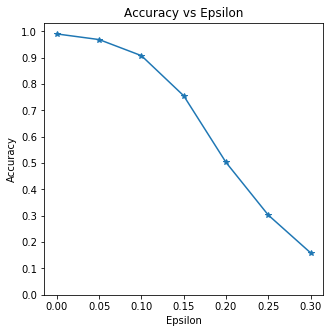

In [7]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

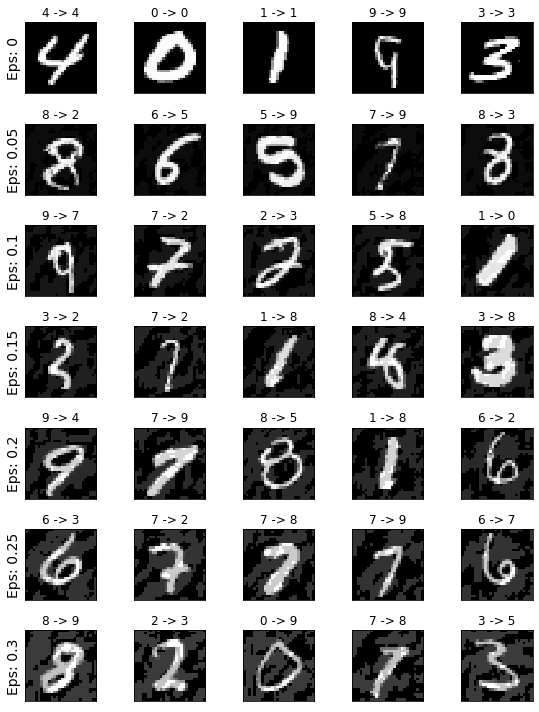

In [8]:
# 在每个epsilon上绘制几个对抗样本的例子
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % 
      (100 * correct / total))

Accuracy of the network on the 10000 test images: 99.04 %


In [15]:
PATH2 = "./mnist_net2.pth" # epoches = 300
pretrained_model = PATH2

In [16]:
mean = 0.1307
std = 0.308

transformtion = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),  # 数据增广
#     transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize((mean,),(std,))]
)
# 

test_dataset = datasets.MNIST('./mnist',train=False,transform = transformtion, download=True)

test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=True, num_workers=4)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        # 输入 1 * 28 * 28
        self.conv = nn.Sequential(
            # 卷积层1
            # 在输入基础上增加了padding，28 * 28 -> 32 * 32
            # 1 * 32 * 32 -> 6 * 28 * 28
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), nn.ReLU(),
            # 6 * 28 * 28 -> 6 * 14 * 14
            nn.MaxPool2d(kernel_size=2, stride=2), # kernel_size, stride
            # 卷积层2
            # 6 * 14 * 14 -> 16 * 10 * 10 
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), nn.ReLU(),
            # 16 * 10 * 10 -> 16 * 5 * 5
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc = nn.Sequential(
            # 全连接层1
            nn.Linear(in_features=16 * 5 * 5, out_features=120), 
            nn.ReLU(),
            # 全连接层2
            nn.Linear(in_features=120, out_features=84), 
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)
        )
    def forward(self, img):
        img = self.conv(img)
        out = img.view(img.size(0),-1)
        out = self.fc(out)
        return out

# 定义我们正在使用的设备
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

model = torch.load(pretrained_model)
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
model = model.to(device)
model

CUDA Available:  True


LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [17]:
accuracies = []
examples = []

# 对每个epsilon运行测试
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9906 / 10000 = 0.9906
Epsilon: 0.05	Test Accuracy = 9839 / 10000 = 0.9839
Epsilon: 0.1	Test Accuracy = 9740 / 10000 = 0.974
Epsilon: 0.15	Test Accuracy = 9611 / 10000 = 0.9611
Epsilon: 0.2	Test Accuracy = 9408 / 10000 = 0.9408
Epsilon: 0.25	Test Accuracy = 9115 / 10000 = 0.9115
Epsilon: 0.3	Test Accuracy = 8688 / 10000 = 0.8688


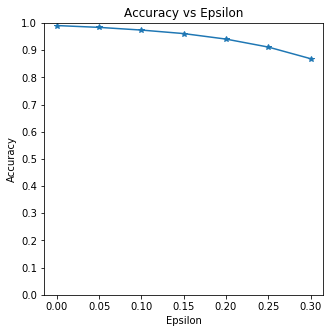

In [18]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

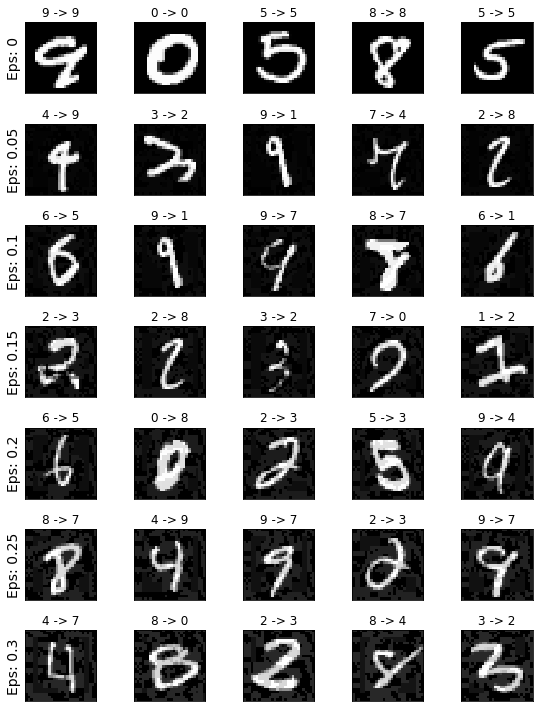

In [19]:
# 在每个epsilon上绘制几个对抗样本的例子
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()